In [1]:
!pip install -q tensorflow_text
!pip install -q tf-models-official==2.11.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.12.2 requires cupy-cuda115, which is not installed.
distributed 20

In [2]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
import tensorflow_text as text  # Registers the ops.
from keras.utils import to_categorical
from official.nlp import optimization  # to create AdamW optimizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_train = pd.read_csv('/kaggle/input/labeled-unreliable-news-lun/fulltrain.csv', encoding='utf-8', names=['label', 'text'])
df_test = pd.read_csv('/kaggle/input/labeled-unreliable-news-lun/balancedtest.csv', encoding='utf-8', names=['label', 'text'])

In [4]:
TEXT_LABELS = {1: 'Satire', 2: 'Hoax', 3: 'Propaganda', 4: 'Reliable'}
df_train['label'] = [TEXT_LABELS[x] for x in df_train['label']]
df_test['label'] = [TEXT_LABELS[x] for x in df_test['label']]

In [5]:
df_train.head()

,label,text
0,Satire,"A little less than a decade ago, hockey fans w..."
1,Satire,The writers of the HBO series The Sopranos too...
2,Satire,Despite claims from the TV news outlet to offe...
3,Satire,After receiving 'subpar' service and experienc...
4,Satire,After watching his beloved Seattle Mariners pr...


In [6]:
df_test.head()

,label,text
0,Satire,When so many actors seem content to churn out ...
1,Satire,In what football insiders are calling an unex...
2,Satire,In a freak accident following Game 3 of the N....
3,Satire,North Koreas official news agency announced to...
4,Satire,The former Alaska Governor Sarah Palin would b...


In [7]:
DOWNSAMPLE = False
DOWNSAMPLE_RATIO = 0.01

# Use stratify sampling to preserve the original class distribution
if DOWNSAMPLE:
    df_train, _ = train_test_split(df_train, train_size=DOWNSAMPLE_RATIO, random_state=42, stratify=df_train['label'])
    df_test, _ = train_test_split(df_test, train_size=DOWNSAMPLE_RATIO, random_state=42, stratify=df_test['label'])

In [8]:
print('Shape of the training data: ', df_train.shape)
print('Shape of the test data: ', df_test.shape)

Shape of the training data:  (48854, 2)
Shape of the test data:  (3000, 2)


In [9]:
# Check the class distribution
df_train.groupby('label').count()

,text
label,
Hoax,6942
Propaganda,17870
Reliable,9995
Satire,14047


In [10]:
# Check the class distribution
df_test.groupby('label').count()

,text
label,
Hoax,750
Propaganda,750
Reliable,750
Satire,750


## Encode the classes

In [11]:
le = LabelEncoder()

X_train = df_train['text']
y_train = le.fit_transform(df_train['label'])

X_test = df_test['text']
y_test = le.transform(df_test['label'])

## Random Oversampling

In [12]:
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train.values.reshape(-1, 1), y_train)

In [13]:
from collections import Counter
print(X_train.shape, y_train.shape)
print(sorted(Counter(y_train).items()))

(71480, 1) (71480,)
[(0, 17870), (1, 17870), (2, 17870), (3, 17870)]


### Convert to one-hot vectors

In [14]:
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [15]:
print(y_train.shape, y_test.shape)

(71480, 4) (3000, 4)


## Split validation set for hyperparameter tuning

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, stratify=y_train)

## BERT Model

In [17]:
# Define the optimizer which uses the same learning rate schedule as BERT pre-training
epochs = 10
batch_size = 32
eval_batch_size = 32

train_data_size = len(X_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=3e-5,
#     decay_steps=10000,
#     decay_rate=0.9)

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw') # by default, 0.01 weight_decay is already included.
# optimizer = tfa.optimizers.LAMB(learning_rate=lr_schedule)


In [18]:
def build_model(num_classes, optimizer, max_seq_length=128):
    
    
    preprocessor = hub.load(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

    # Step 1: tokenize batches of text inputs.
    text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string)]
    tokenize = hub.KerasLayer(preprocessor.tokenize)
    tokenized_inputs = [tokenize(segment) for segment in text_inputs]

    # Step 2 (optional): modify tokenized inputs.
    pass

    # Step 3: pack input sequences for the Transformer encoder.
    seq_length = max_seq_length
    bert_pack_inputs = hub.KerasLayer(
        preprocessor.bert_pack_inputs,
        arguments=dict(seq_length=seq_length))  # Optional argument.
    encoder_inputs = bert_pack_inputs(tokenized_inputs)
         
    encoder = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-8-h-768-a-12/versions/2",
                             trainable=False, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    out = tf.keras.layers.Dense(num_classes, activation='softmax', name='classifier')(net)
    
    
    model = tf.keras.models.Model(text_inputs, out)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy', tfa.metrics.F1Score(num_classes=num_classes, average='macro')])
    
    return model

In [19]:
model = build_model(num_classes=len(TEXT_LABELS), optimizer=optimizer, max_seq_length=512)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, None, None)   0           ['input_1[0][0]']                
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_mask': (Non  0           ['keras_layer[0][0]']            
                                e, 512),                                                          
                                 'input_type_ids':                                                
                                (None, 512),                                                  

In [20]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('weights-{epoch:02d}-{val_loss:.2f}', monitor='val_accuracy', save_best_only=False, save_weights_only=False, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

history = model.fit(x=X_train,
          y=y_train,
          validation_data=(X_val, y_val),
          epochs=epochs, 
          callbacks=[checkpoint, early_stopping], 
          batch_size=batch_size,
          validation_batch_size=eval_batch_size,
          verbose=1)

Epoch 1/10
2011/2011 [==============================] - ETA: 0s - loss: 0.9100 - accuracy: 0.6409 - f1_score: 0.6397
Epoch 1: saving model to weights-01-0.42
2011/2011 [==============================] - 1259s 621ms/step - loss: 0.9100 - accuracy: 0.6409 - f1_score: 0.6397 - val_loss: 0.4201 - val_accuracy: 0.8713 - val_f1_score: 0.8709
Epoch 2/10
2011/2011 [==============================] - ETA: 0s - loss: 0.3694 - accuracy: 0.8739 - f1_score: 0.8738
Epoch 2: saving model to weights-02-0.29
2011/2011 [==============================] - 1250s 622ms/step - loss: 0.3694 - accuracy: 0.8739 - f1_score: 0.8738 - val_loss: 0.2856 - val_accuracy: 0.9064 - val_f1_score: 0.9063
Epoch 3/10
2011/2011 [==============================] - ETA: 0s - loss: 0.2873 - accuracy: 0.8998 - f1_score: 0.8997
Epoch 3: saving model to weights-03-0.24
2011/2011 [==============================] - 1251s 622ms/step - loss: 0.2873 - accuracy: 0.8998 - f1_score: 0.8997 - val_loss: 0.2373 - val_accuracy: 0.9224 - val_f1_

In [21]:
def plot_loss(history):
    # plot learning curves
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.tight_layout()

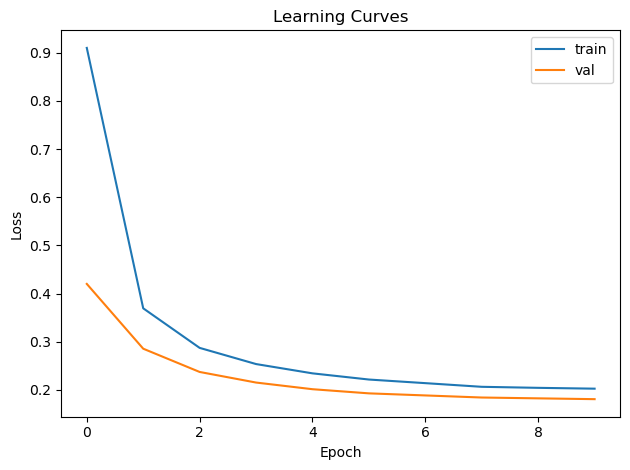

In [22]:
plot_loss(history)

## Evaluation

In [23]:
X_test = df_test['text']
y_test = le.transform(df_test['label'])

In [24]:
y_proba = model.predict(X_test, batch_size=eval_batch_size)
y_pred = np.argmax(y_proba, axis=1)
y_pred_labels = le.inverse_transform(y_pred)
y_true_labels = le.inverse_transform(y_test)

94/94 [==============================] - 51s 543ms/step


In [25]:
print(classification_report(y_true=y_true_labels, y_pred=y_pred_labels))
print(confusion_matrix(y_true_labels, y_pred_labels))

              precision    recall  f1-score   support

        Hoax       0.52      0.37      0.44       750
  Propaganda       0.44      0.52      0.48       750
    Reliable       0.66      0.88      0.75       750
      Satire       0.74      0.55      0.63       750

    accuracy                           0.58      3000
   macro avg       0.59      0.58      0.57      3000
weighted avg       0.59      0.58      0.57      3000

[[281 442  15  12]
 [  8 392 264  86]
 [ 11  30 661  48]
 [241  27  69 413]]
